In [1]:
%pip install 'pytorchfire[examples]'
%pip install requests
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download the dataset

import requests

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

file_url = 'https://data.mendeley.com/public-files/datasets/nx2wsksp9k/files/a2e9f5a0-187e-4dc5-9b7b-60b79645a9aa/file_downloaded'
filename = 'simulated_fig_targets.hdf5'
download_file(file_url, filename)

print(f"Dataset downloaded and saved as {filename}")


Dataset downloaded and saved as simulated_fig_targets.hdf5


In [3]:
# Run the simulation

import h5py
from pytorchfire import WildfireModel
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

with h5py.File('simulated_fig_targets.hdf5', 'r') as f_in:
    ds = f_in['Bear_2020']
    
    model = WildfireModel({
            'p_veg': torch.tensor(ds['p_veg'][:]),
            'p_den': torch.tensor(ds['p_den'][:]),
            'wind_towards_direction': torch.tensor(ds['wind_towards_direction'][:][0]),
            'wind_velocity': torch.tensor(ds['wind_velocity'][:][0]),
            'slope': torch.tensor(ds['slope'][:]),
            'initial_ignition': torch.tensor(ds['initial_ignition'][:], dtype=torch.bool)
        }, {
            'a': torch.tensor(ds.attrs['a']),
            'p_h': torch.tensor(ds.attrs['p_h']),
            'p_continue': torch.tensor(ds.attrs['p_continue']),
            'c_1': torch.tensor(ds.attrs['c_1']),
            'c_2': torch.tensor(ds.attrs['c_2']),
        })
    
    wind_step_interval = ds.attrs['wind_step_interval']
    max_steps = ds.attrs['max_steps']
    
    model.to(device)
    model.eval()
    
    affected_cell_count_outputs = []
    affected_cell_count_targets = []

    postfix = {}
    output_list = []
    
    with tqdm(total=max_steps) as progress_bar:
            with torch.no_grad():
                for steps in range(max_steps):
                    postfix['steps'] = f'{steps + 1}/{max_steps}'

                    if steps % wind_step_interval == 0:
                        model.wind_towards_direction = torch.tensor(
                            ds['wind_towards_direction'][steps // wind_step_interval], device=device)
                        model.wind_velocity = torch.tensor(ds['wind_velocity'][steps // wind_step_interval],
                                                                device=device)

                    model.compute()
                    outputs = model.state[0] | model.state[1]

                    postfix['burning'] = model.state[0].sum().detach().cpu().item()
                    postfix['burned'] = model.state[1].sum().detach().cpu().item()

                    output_list.append(outputs.cpu().detach().numpy())

                    progress_bar.set_postfix(postfix)
                    progress_bar.update(1)
    

Using device: cuda


100%|██████████| 300/300 [00:02<00:00, 122.72it/s, steps=300/300, burning=1364, burned=130747]


MovieWriter ffmpeg unavailable; using Pillow instead.


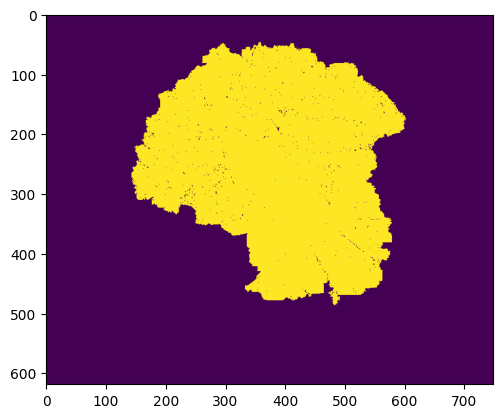

In [4]:
# Visualize the simulation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

im = ax.imshow(output_list[0])

def update(frame):
    im.set_array(output_list[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(output_list), interval=100, blit=True
)

ani.save('fire_prediction.gif', fps=10)
HTML(ani.to_jshtml())

![Animation](fire_prediction.gif)